In [16]:
import os

import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

# better pictures and legends
plt.rc('figure', dpi=150)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=10)

berlin = {
    "U7": "#009AD9",
    "U3": "#00A192",
    "U1": "#62AD2D",
    "U2": "#E94D10",
    "U4": "#FFD401",
    "U5": "#815237",
    "U6": "#846DAA",
    "U8": "#005A99",
    "U9": "#F18800",
}

zoo_berlin = [berlin["U1"], berlin["U2"], berlin["U9"], ]
palette = [berlin[key] for key in berlin]

plt.rc('axes', prop_cycle=cycler(color=palette))

dx=0.125, dt=0.00625


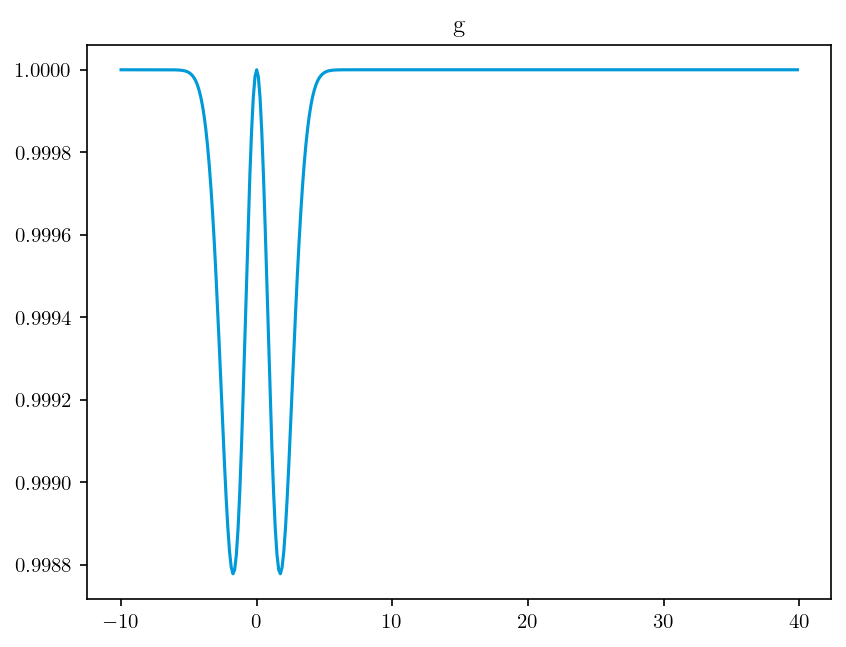

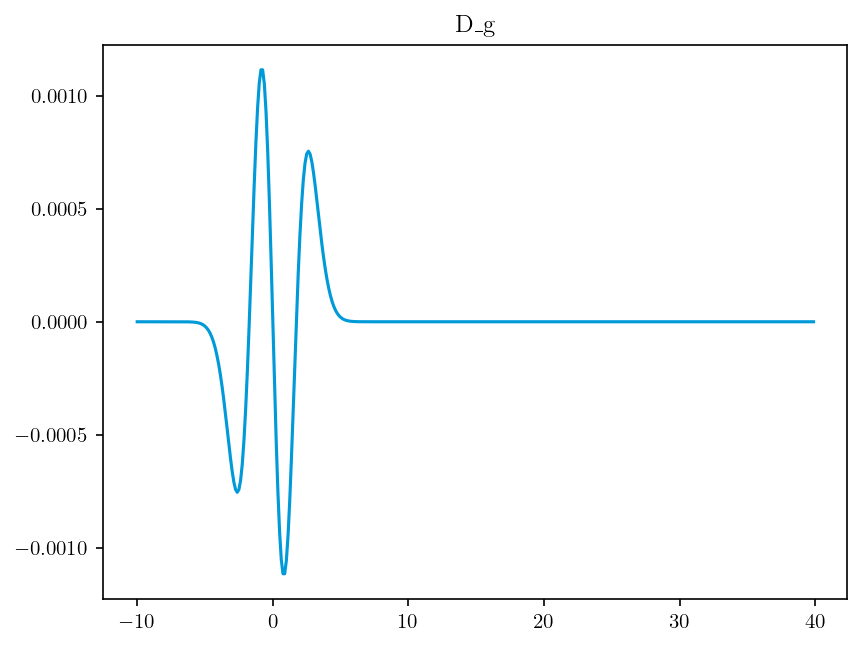

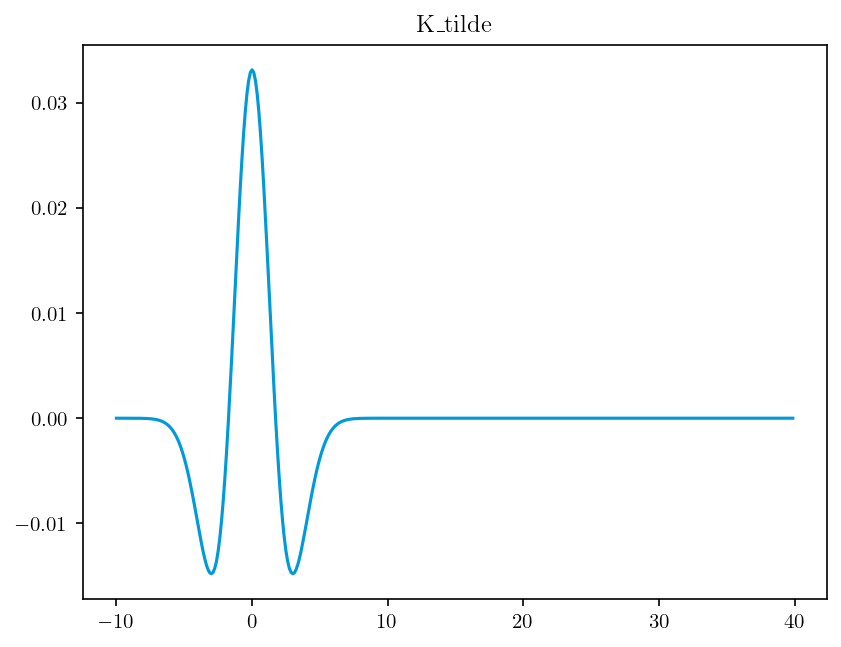

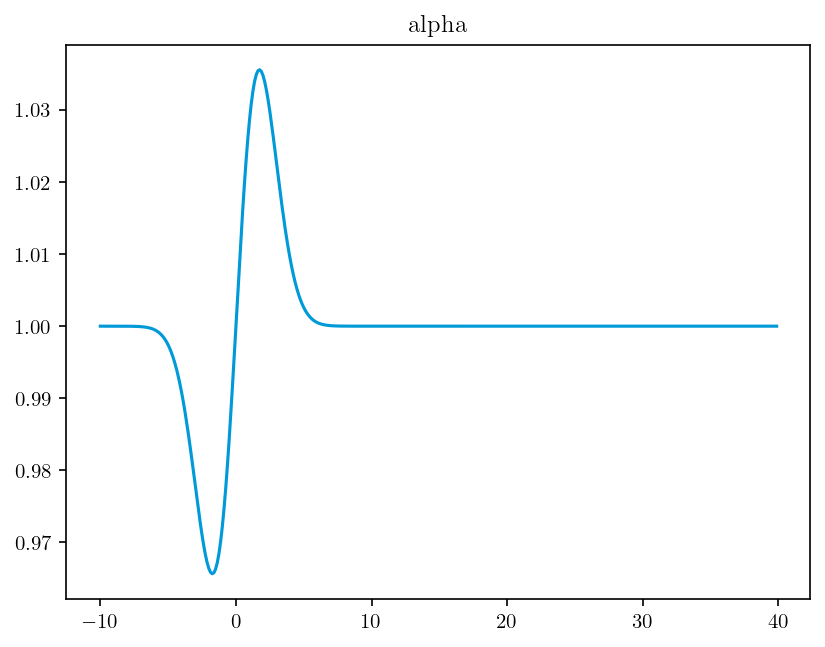

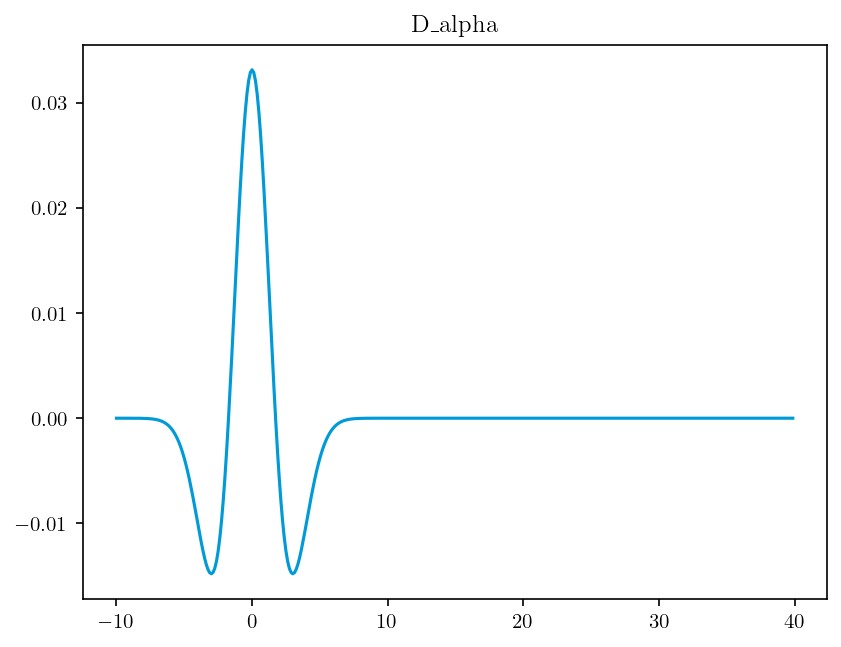

In [17]:
def fd2(u, h):
    u_prime = np.zeros_like(u)
    for i in np.arange(1, N-1):
        u_prime[i] = (u[i+1]-u[i-1]) / (2*h)
    # Vector version, way faster in NumPy
    # u_prime[1:-1] = (u[2:]-u[:-2]) / (2*h)

    # For the boundary points
    u_prime[0] = (u[1] - u[-1]) / (2*h)
    u_prime[-1] = (u[0]-u[-2]) / (2*h)
    return u_prime

def deriv(u, h):
    return fd2(u,h)

N = 400
x, dx = np.linspace(-10, 40, N, endpoint=False, retstep=True)


dt=0.05*dx

print(f'dx={dx}, dt={dt}')
t_final = 10
f = 1.0

# Time function
hp = 0.1 * np.exp(-x**2/6)

# Initial conditions
g0 = 1 - deriv(hp, dx)**2


U0 = {
    "g": g0,
    "D_g" : -2 * deriv(hp,dx) * deriv(deriv(hp,dx),dx) / g0,
    "K_tilde": -deriv(deriv(hp,dx), dx)/g0,
    "alpha": ( (1-deriv(hp, dx))/(1+deriv(hp,dx)) )**(np.sqrt(f)/2),
    "D_alpha": -np.sqrt(f) * deriv(deriv(hp, dx), dx)/g0,
}

def rhs_on_state_vector(U, varname):
    g = U["g"]
    D_g = U["D_g"],
    K_tilde = U["K_tilde"]
    K = K_tilde / np.sqrt(g)
    alpha = U["alpha"]
    D_alpha = U["D_alpha"]

    RHS = {
        "g": lambda: - 2 * alpha * g * K,
        "D_g": lambda: -deriv(2 * alpha * K, dx),
        "K_tilde": lambda: - deriv(alpha*D_alpha/np.sqrt(g),dx),
        "alpha": lambda: - alpha**2 *f* K,
        "D_alpha": lambda: -deriv(alpha * f * K, dx),
        }
    return RHS[varname]()

def vadd(U, varname, B):
    Ua = U.copy() # Same vector
    Ua[varname] = Ua[varname] + B # But with modified variable
    return Ua

t=dt
n=0
U = U0

def plot(us):
    for u in us:
        plt.plot(x, u)
    plt.show()
    plt.close('all')

# Plot the initial data
for varname in U:
    plt.plot(x, U[varname])
    plt.title(varname)
    plt.show()
    plt.close('all')

plot_every_nth_iteration = 5

# Evolve
while t < t_final:
    if n%plot_every_nth_iteration == 0:
        ax = plt.gca()
        ax.plot(x, U["alpha"])
        ax.set_title(f't={t}')
        ax.set_ylim((0.9, 1.1))
        # plt.show()
        os.makedirs('frames', exist_ok=True)
        plt.savefig(f'frames/alpha.{n:04d}.png')
        plt.close('all')

    U_ret={}
    # Update all the variables
    for varname in U:
        k1 = rhs_on_state_vector(U, varname)
        k2 = rhs_on_state_vector(vadd(U, varname, k1 * dt/2), varname)
        k3 = rhs_on_state_vector(vadd(U, varname, k2 * dt/2), varname)
        k4 = rhs_on_state_vector(vadd(U, varname, k3 * dt  ), varname)
        
        U_ret[varname] = U[varname] + (k1/6 + k2/3 + k3/3 + k4/6)*dt
    U = U_ret

    t += dt
    n += 1